## Problem

You are given data from an Audiobook app. Logically, it relates only to the audio versions of books. Each customer in the database has made a purchase at least once, that's why he/she is in the database. We want to create a machine learning algorithm based on our available data that can predict if a customer will buy again from the Audiobook company.

The main idea is that if a customer has a low probability of coming back, there is no reason to spend any money on advertizing to him/her. If we can focus our efforts ONLY on customers that are likely to convert again, we can make great savings. Moreover, this model can identify the most important metrics for a customer to come back again. Identifying new customers creates value and growth opportunities.

You have a .csv summarizing the data. There are several variables: Customer ID, Book length in mins_avg (average of all purchases), Book length in minutes_sum (sum of all purchases), Price Paid_avg (average of all purchases), Price paid_sum (sum of all purchases), Review (a Boolean variable), Review (out of 10), Total minutes listened, Completion (from 0 to 1), Support requests (number), and Last visited minus purchase date (in days).

So these are the inputs (excluding customer ID, as it is completely arbitrary. It's more like a name, than a number).

The targets are a Boolean variable (so 0, or 1). We are taking a period of 2 years in our inputs, and the next 6 months as targets. So, in fact, we are predicting if: based on the last 2 years of activity and engagement, a customer will convert in the next 6 months. 6 months sounds like a reasonable time. If they don't convert after 6 months, chances are they've gone to a competitor or didn't like the Audiobook way of digesting information.

The task is simple: create a machine learning algorithm, which is able to predict if a customer will buy again.

This is a classification problem with two classes: won't buy and will buy, represented by 0s and 1s.

Good luck!


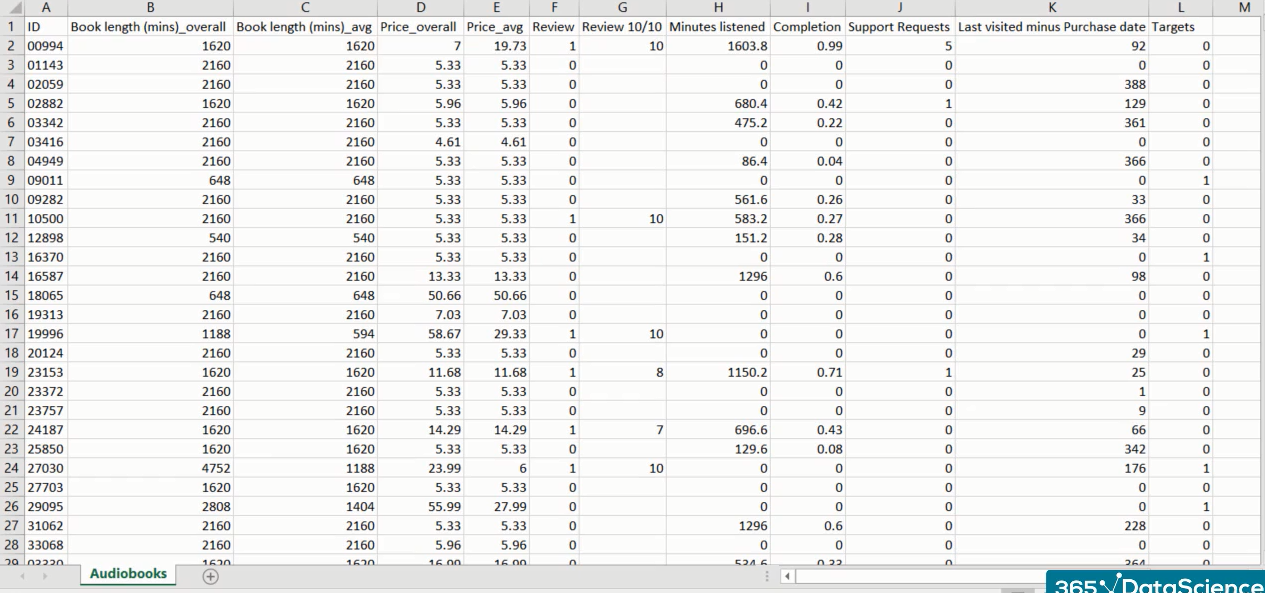

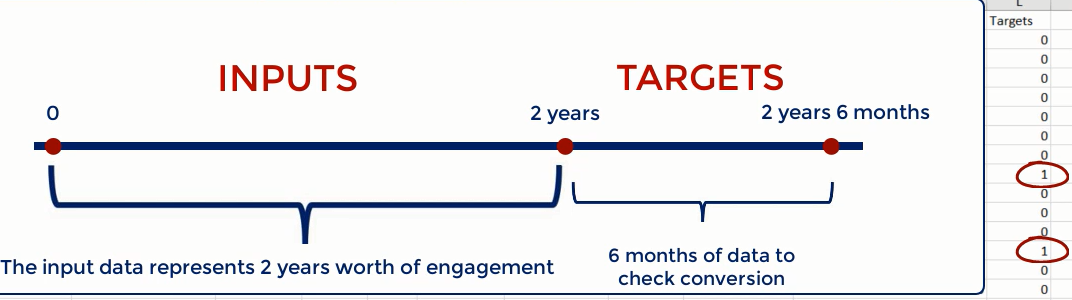


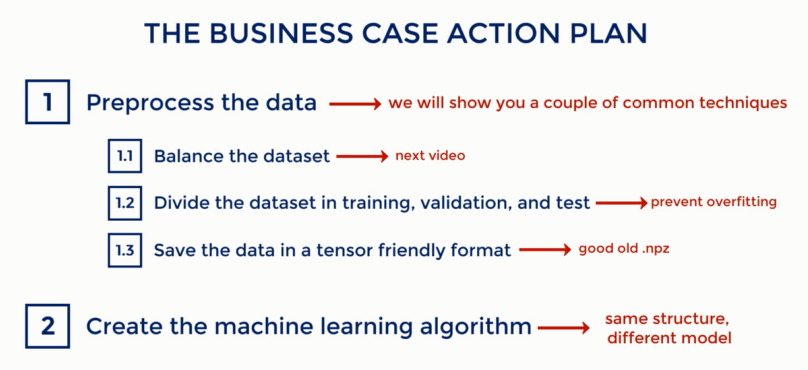


1. Loading the dataset


In [1]:
# import
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing


# data = pd.read_csv(
#     "C:/Users/HP 840 G1/Documents/VS Code Projects/Workspace Learning/DataScience/DataScienceInPython/Drawable/9.Audiobooks_data.csv",
# )

data = np.loadtxt(
    "C:/Users/HP 840 G1/Documents/VS Code Projects/Workspace Learning/DataScience/DataScienceInPython/Drawable/9.Audiobooks_data.csv",
    delimiter=",",
)

# skip the first column which contains id, is not necessary
unscaled_inputs_all = data[:, 1:-1]
# take only target column
targets_all = data[:, -1]

# data_unscaled_inputs_all.head()
targets_all[:5]


array([0., 0., 0., 0., 0.])

2. Preprocess the Data


- Balance the dataset


In [2]:
# count the number of 1's
num_one_targets = int(np.sum(targets_all))

zero_targets_counter = 0
indices_to_remove = []

# iterate all the targets, here shape[0] is the lenth of the vector
for i in range(targets_all.shape[0]):
    if targets_all[i] == 0:
        zero_targets_counter += 1
        if zero_targets_counter > num_one_targets:
            indices_to_remove.append(i)

unscaled_inputs_equal_priors = np.delete(unscaled_inputs_all, indices_to_remove, axis=0)

targets_equal_priors = np.delete(targets_all, indices_to_remove, axis=0)

- Standadize the inputs


In [3]:
scaled_inputs = preprocessing.scale(unscaled_inputs_equal_priors)


- Shuffle the data


In [4]:
shuffled_indices = np.arange(scaled_inputs.shape[0])
np.random.shuffle(shuffled_indices)

shuffled_inputs = scaled_inputs[shuffled_indices]
shuffled_targets = targets_equal_priors[shuffled_indices]


- Split the dataset into train validation and test


In [5]:
samples_count = shuffled_inputs.shape[0]
train_samples_count = int(0.8 * samples_count)
validation_samples_count = int(0.1 * samples_count)
test_samples_count = samples_count - \
    (train_samples_count + validation_samples_count)

# train
train_inputs = shuffled_inputs[:train_samples_count]
train_targets = shuffled_targets[:train_samples_count]

# validation
validation_inputs = shuffled_inputs[
    train_samples_count: train_samples_count + validation_samples_count
]
validation_targets = shuffled_targets[
    train_samples_count: train_samples_count + validation_samples_count
]

# test
test_inputs = shuffled_inputs[train_samples_count + validation_samples_count:]
test_targets = shuffled_targets[train_samples_count +
                                validation_samples_count:]

# checking its a balanced dataset
print(
    np.sum(train_targets),
    train_samples_count,
    np.sum(train_targets) / train_samples_count,
)

print(
    np.sum(validation_targets),
    validation_samples_count,
    np.sum(validation_targets) / validation_samples_count,
)

print(
    np.sum(test_targets), test_samples_count, np.sum(
        test_targets) / test_samples_count
)


1786.0 3579 0.4990220732048058
226.0 447 0.5055928411633109
225.0 448 0.5022321428571429


- Save the three datasets in \*.npz format


In [6]:
np.savez("Audiobooks_data_train", inputs=train_inputs, targets=train_targets)
np.savez(
    "Audiobooks_data_validation", inputs=validation_inputs, targets=validation_targets
)
np.savez("Audiobooks_data_test", inputs=test_inputs, targets=test_targets)


3. Create the machine learning algorithm


- Load the data


In [7]:
# load train data
npz = np.load("Audiobooks_data_train.npz")
train_inputs = npz["inputs"].astype(np.float32)
train_targets = npz["targets"].astype(np.int64)

# load validation data
npz = np.load("Audiobooks_data_validation.npz")
validation_inputs, validation_targets = npz["inputs"].astype(np.float32), npz[
    "targets"
].astype(np.int64)

# load test data
npz = np.load("Audiobooks_data_test.npz")
test_inputs = npz["inputs"].astype(np.float32)
test_targets = npz["targets"].astype(np.int64)


- Model

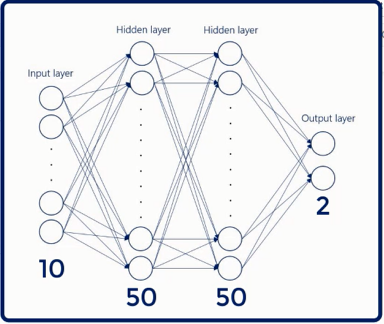


- - Outline the model

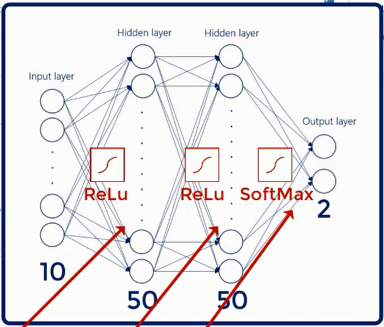


In [8]:
input_size = 10
output_size = 2
hidden_layer_size = 50

model = tf.keras.Sequential(
    [
        # tf.keras.layers.Dense is basically implementing: output = activation(dot(input, weight) + bias)
        # it takes several arguments, but the most important ones for us are the hidden_layer_size and the activation function
        tf.keras.layers.Dense(hidden_layer_size, activation="relu"),
        tf.keras.layers.Dense(hidden_layer_size, activation="relu"),
        # the final layer is no different, we just make sure to activate it with softmax
        tf.keras.layers.Dense(output_size, activation="softmax"),
    ]
)


- - Model optimization

- - - Optimization = Adaptive Momentum Estimator

- - - Loss = Sparse Categorial Crossentropy

- - - Accuracy metrics of the model


In [9]:
# Choose the optimizer and the loss function

# we define the optimizer we'd like to use,
# the loss function,
# and the metrics we are interested in obtaining at each iteration

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)


- - Model training


In [10]:
# batch size
batch_size = 100
max_epochs = 100

# fitting the model
model.fit(
    train_inputs,
    train_targets,
    batch_size=batch_size,
    epochs=max_epochs,
    validation_data=(validation_inputs, validation_targets),
    verbose=1,
)


Epoch 1/100


36/36 [==============================] - 3s 13ms/step - loss: 0.6161 - accuracy: 0.6457 - val_loss: 0.5079 - val_accuracy: 0.7338
Epoch 2/100
36/36 [==============================] - 0s 4ms/step - loss: 0.4861 - accuracy: 0.7365 - val_loss: 0.4312 - val_accuracy: 0.7673
Epoch 3/100
36/36 [==============================] - 0s 4ms/step - loss: 0.4286 - accuracy: 0.7748 - val_loss: 0.4041 - val_accuracy: 0.7606
Epoch 4/100
36/36 [==============================] - 0s 4ms/step - loss: 0.3968 - accuracy: 0.7849 - val_loss: 0.3932 - val_accuracy: 0.7830
Epoch 5/100
36/36 [==============================] - 0s 4ms/step - loss: 0.3797 - accuracy: 0.7935 - val_loss: 0.3888 - val_accuracy: 0.7763
Epoch 6/100
36/36 [==============================] - 0s 4ms/step - loss: 0.3684 - accuracy: 0.8066 - val_loss: 0.3766 - val_accuracy: 0.7875
Epoch 7/100
36/36 [==============================] - 0s 4ms/step - loss: 0.3602 - accuracy: 0.8030 - val_loss: 0.3666 - val_accuracy: 0.7942
Epoch 8/100
36/36 [=====

- - Model training with Early stoping technique


In [11]:
# batch size
batch_size = 100
max_epochs = 100

# set an early stopping mechanism
# let's set patience=2, to be a bit tolerant against random validation loss increases
early_stopping = tf.keras.callbacks.EarlyStopping(patience=4)

# fitting the model
model.fit(
    train_inputs,
    train_targets,
    batch_size=batch_size,
    epochs=max_epochs,
    callbacks=[early_stopping],  # early stopping
    validation_data=(validation_inputs, validation_targets),
    verbose=1,
)


Epoch 1/100
36/36 [==============================] - 0s 6ms/step - loss: 0.3027 - accuracy: 0.8321 - val_loss: 0.3477 - val_accuracy: 0.8009
Epoch 2/100
36/36 [==============================] - 0s 4ms/step - loss: 0.3014 - accuracy: 0.8351 - val_loss: 0.3345 - val_accuracy: 0.8121
Epoch 3/100
36/36 [==============================] - 0s 4ms/step - loss: 0.3040 - accuracy: 0.8335 - val_loss: 0.3419 - val_accuracy: 0.8054
Epoch 4/100
36/36 [==============================] - 0s 4ms/step - loss: 0.3040 - accuracy: 0.8321 - val_loss: 0.3482 - val_accuracy: 0.8188
Epoch 5/100
36/36 [==============================] - 0s 4ms/step - loss: 0.3046 - accuracy: 0.8326 - val_loss: 0.3391 - val_accuracy: 0.8143
Epoch 6/100
36/36 [==============================] - 0s 4ms/step - loss: 0.3038 - accuracy: 0.8374 - val_loss: 0.3428 - val_accuracy: 0.8255


- - Test the model

As we discussed in the lectures, after training on the training data and validating on the validation data, we test the final prediction power of our model by running it on the test dataset that the algorithm has NEVER seen before.

It is very important to realize that fiddling with the hyperparameters overfits the validation dataset.

The test is the absolute final instance. You should not test before you are completely done with adjusting your model.

If you adjust your model after testing, you will start overfitting the test dataset, which will defeat its purpose.


In [12]:
test_loss, test_accuracy = model.evaluate(test_inputs, test_targets)
print(
    "\nTest loss: {0:.2f}. Test accuracy: {1:.2f}%".format(
        test_loss, test_accuracy * 100.0
    )
)

14/14 [==============================] - 0s 6ms/step - loss: 0.3389 - accuracy: 0.7991

Test loss: 0.34. Test accuracy: 79.91%
